# TODO: Data Preperation and Analysis Notebook
**TODO**: This notebook is prepared for fetching the required data, splitting it into Train/Test/Validation sets, and also uploading these sets to S3 Bucket. 

Afterwards, some descriptive analysis was made to explore the distributions of dataset

In [18]:
# TODO: Import any packages that you might need
import json
import random
import os
import json
import boto3
from tqdm import tqdm
import numpy as np
import shutil
import pandas as pd
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'\n\nfrom sagemaker import Session\nfrom sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner, HyperparameterTuningJobAnalytics)\nfrom sagemaker.pytorch import PyTorch\nfrom sagemaker.debugger import (Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile)\nfrom sagemaker.pytorch import PyTorchModel\nfrom sagemaker.predictor import Predictor\nfrom sagemaker.serializers import IdentitySerializer\n\nfrom smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob\nfrom smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts\n\n\nimport boto3\n\nimport os\nimport io\n\nfrom tqdm import tqdm\nimport IPython\nfrom PIL import Image\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport torchvision.transforms as transforms\n'

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [1]:
def create_dataset_splits(data_dir):
    with open(data_dir, 'r') as f:
        d=json.load(f)

    train = {}
    valid = {}
    test = {}
    for k, v in d.items():
        l = len(v)
        print("%s has %d items" % (k, l))
        random.shuffle(v)
        i = (int)(0.8 * l)
        j = (int)(0.9 * l)
        train[k] = v[:i]
        valid[k] = v[i:j]
        test[k] = v[j:]
        print("%s:%s:%s" % (len(train[k]), len(valid[k]), len(test[k])))

    with open('train_data.json', 'w') as f:
        json.dump(train, f)
    with open('valid_data.json', 'w') as f:
        json.dump(valid, f)
    with open('test_data.json', 'w') as f:
        json.dump(test, f)

In [6]:
create_dataset_splits('file_list.json')

1 has 1228 items
982:123:123
2 has 2299 items
1839:230:230
3 has 2666 items
2132:267:267
4 has 2373 items
1898:237:238
5 has 1875 items
1500:187:188


In [8]:
s3_client = boto3.client('s3')

def download_and_arrange_data(folder):
    s3_client = boto3.client('s3')

    with open(f"{folder}.json", 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join(folder, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

# download_and_arrange_data()

In [ ]:
download_and_arrange_data('train_data')
download_and_arrange_data('valid_data')
download_and_arrange_data('test_data')

## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [ ]:
#TODO: Perform any data cleaning or data preprocessing

In [ ]:
#TODO: Upload the data to AWS S3

In [9]:
!ls -al train_data valid_data test_data

test_data:
total 60
drwxr-xr-x 7 sagemaker-user users   51 Jul  6 14:41 .
drwxr-xr-x 7 sagemaker-user users 4096 Jul 13 15:17 ..
drwxr-xr-x 2 sagemaker-user users 4096 Jul  6 14:41 1
drwxr-xr-x 2 sagemaker-user users 8192 Jul  6 14:41 2
drwxr-xr-x 2 sagemaker-user users 8192 Jul  6 14:41 3
drwxr-xr-x 2 sagemaker-user users 8192 Jul  6 14:41 4
drwxr-xr-x 2 sagemaker-user users 8192 Jul  6 14:42 5

train_data:
total 448
drwxr-xr-x 7 sagemaker-user users    51 Jul  6 14:37 .
drwxr-xr-x 7 sagemaker-user users  4096 Jul 13 15:17 ..
drwxr-xr-x 2 sagemaker-user users 28672 Jul  6 14:30 1
drwxr-xr-x 2 sagemaker-user users 53248 Jul  6 14:32 2
drwxr-xr-x 2 sagemaker-user users 81920 Jul  6 14:35 3
drwxr-xr-x 2 sagemaker-user users 73728 Jul  6 14:37 4
drwxr-xr-x 3 sagemaker-user users 73728 Jul  6 18:30 5

valid_data:
total 60
drwxr-xr-x 7 sagemaker-user users   51 Jul  6 14:40 .
drwxr-xr-x 7 sagemaker-user users 4096 Jul 13 15:17 ..
drwxr-xr-x 2 sagemaker-user users 4096 Jul  6 14:39 1
drwxr-x

In [12]:
with open('file_list.json', 'r') as f:
    d = json.load(f)

quantities = []
file_names = []
for k, v in d.items():
    quantities.append([k] * len(v))
    file_names.append(v)
    print("%s has %d items" % (k, len(v)))

quantities = [item for sublist in quantities for item in sublist]
file_names = [item for sublist in file_names for item in sublist]

df = pd.DataFrame({"data": file_names, "quantity": quantities})

1 has 1228 items
2 has 2299 items
3 has 2666 items
4 has 2373 items
5 has 1875 items


In [13]:
df.head()

,data,quantity
0,data/metadata/100313.json,1
1,data/metadata/09915.json,1
2,data/metadata/103299.json,1
3,data/metadata/00710.json,1
4,data/metadata/05397.json,1


In [14]:
df["quantity"] = pd.to_numeric(df["quantity"])

In [15]:
df.describe()

,quantity
count,10441.000000
mean,3.131022
std,1.272490
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


<Axes: >

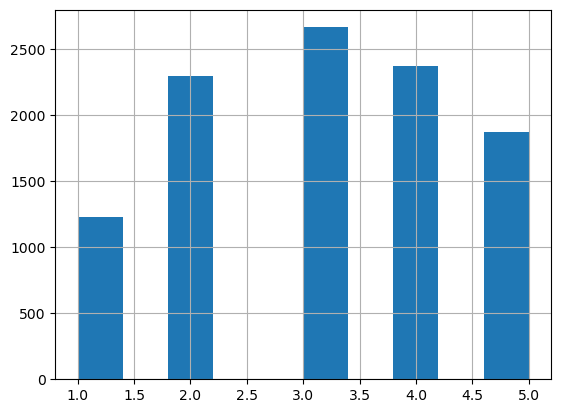

In [16]:
# This part shows the quantities of objects in the dataset images, frequency of target variable
df["quantity"].hist()

In [19]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [20]:
print(f"Default Bucket: {bucket}")
print(f"RoleArn: {role}")

Default Bucket: sagemaker-us-east-1-462848125024
RoleArn: arn:aws:iam::462848125024:role/service-role/AmazonSageMaker-ExecutionRole-20240606T225120


In [21]:
# This cell needs to be run at first time. from second time on, we don't need to run it
# This cell is required to upload our splitted dataset into S3 bucket

def upload_to_s3(local_dir, bucket, prefix):
    inputs = sagemaker_session.upload_data(path=local_dir,  bucket=bucket,  key_prefix=prefix)
    return inputs

prefix = "aws_capstone_project"

In [ ]:
train = upload_to_s3("train_data", bucket, prefix)
print(f"input spec (in this case, just an S3 path): {train}")

In [ ]:
valid = upload_to_s3("valid_data", bucket, prefix)
print(f"input spec (in this case, just an S3 path): {valid}")

In [ ]:
test = upload_to_s3("test_data", bucket, prefix)
print(f"input spec (in this case, just an S3 path): {test}")

In [ ]:
!aws s3 cp train_data s3://sagemaker-us-east-1-462848125024/aws_capstone_project/train_data --recursive

In [ ]:
!aws s3 cp valid_data s3://sagemaker-us-east-1-462848125024/aws_capstone_project/valid_data --recursive

In [ ]:
!aws s3 cp test_data s3://sagemaker-us-east-1-462848125024/aws_capstone_project/test_data --recursive

In [2]:
train = "s3://sagemaker-us-east-1-462848125024/aws_capstone_project/train_data/"
valid = "s3://sagemaker-us-east-1-462848125024/aws_capstone_project/valid_data/"
test = "s3://sagemaker-us-east-1-462848125024/aws_capstone_project/test_data/"